In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.stochastic_processes.bases import ContinuousTimeProcess
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.solvers.sde import Euler

**$\mathbb{P}$: OU process**
$$
\mathrm{d}X_t = -\gamma\cdot X_t\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^*$: OU Bridge**
$$
\mathrm{d}X^*_t = \left\{ -\gamma\cdot X_t + \frac{4\gamma^2e^{-\gamma(T-t)}(X^*_t\cdot e^{-\gamma(T-t)} - X_T)}{e^{-2\gamma(T-t)} - 1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\circ$: Brownian bridge**
$$
\mathrm{d}X^\circ_t = \frac{X_T-X^\circ_t}{T-t}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\diamond$: Brownian bridge + NN**
$$
\mathrm{d}X^\diamond_t = \left\{\frac{X_T-X^\diamond_t}{T-t} + \sigma\cdot\nu_\theta(t, X^\diamond_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Set $\sigma=\gamma=1$

In [41]:
sigma = 1.0
gamma = 1.0
T = 1.0
xT = jnp.array([1.0])

def ou_drift(t, x):
    return -gamma * x

def brownian_drift(t, x):
    return jnp.asarray(0.0)

def ou_bridge_drift(t, x):
    return -gamma * x + \
        4.0 * gamma**2 * jnp.exp(-gamma * (T - t)) \
            * (x * jnp.exp(-gamma * (T - t)) - xT) / (jnp.exp(-2.0 * gamma * (T - t)) - 1.0)

def brownian_bridge_drift(t, x):
    return (xT - x) / (T - t)

def brownian_mixed_bridge_drift(t, x, nu):
    return brownian_drift(t, x) + sigma * nu(t, x)

In [42]:
class OUProcess(ContinuousTimeProcess):
    dim = 1
    dtype = jnp.float32
    T = 1.0
    dt = 1e-2
    
    def __init__(self):
        super().__init__()
    
    def f(self, t, x):
        return ou_drift(t, x)

    def g(self, t, x):
        return jnp.array([sigma])
    
    def Sigma(self, t, x):
        return jnp.array([sigma**2])
    
class OUBridgeProcess(ContinuousTimeProcess):
    dim = 1
    dtype = jnp.float32
    T = 1.0
    dt = 1e-2
    
    def __init__(self):
        super().__init__()
    
    def f(self, t, x):
        return ou_bridge_drift(t, x)

    def g(self, t, x):
        return jnp.array([sigma])
    
    def Sigma(self, t, x):
        return jnp.array([sigma**2])
    
class BrownianBridgeProcess(ContinuousTimeProcess):
    dim = 1
    dtype = jnp.float32
    T = 1.0
    dt = 1e-2
    
    def __init__(self):
        super().__init__()
    
    def f(self, t, x):
        return brownian_bridge_drift(t, x)

    def g(self, t, x):
        return jnp.array([1.0])
    
    def Sigma(self, t, x):
        return jnp.array([1.0])

In [43]:
key = jax.random.PRNGKey(32)
wiener_process = WienerProcess(dim=1, dtype=jnp.float32, rng_key=key)
ou_sde = OUProcess()
ou_bridge_sde = OUBridgeProcess()
brownian_bridge_sde = BrownianBridgeProcess()

In [44]:
ou_solver = Euler(ou_sde)
ou_bridge_solver = Euler(ou_bridge_sde)
brownian_bridge_solver = Euler(brownian_bridge_sde)

In [45]:
dWs = wiener_process.sample_path(ou_sde.ts).xs
ou_path = ou_solver.solve(x0=jnp.array([0.0]), dWs=dWs)
ou_bridge_path = ou_bridge_solver.solve(x0=jnp.array([0.0]), dWs=dWs)
brownian_bridge_path = brownian_bridge_solver.solve(x0=jnp.array([0.0]), dWs=dWs)

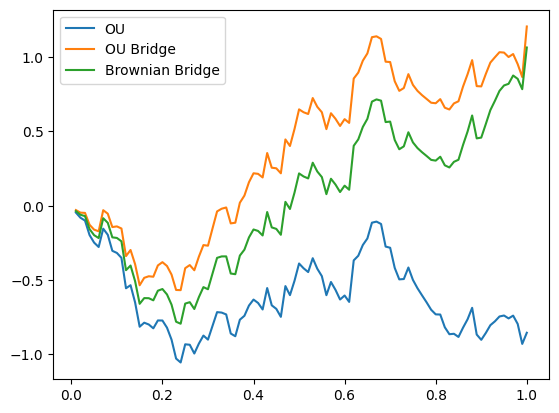

In [47]:
plt.plot(ou_sde.ts[1:], ou_path.xs[:, 0], label="OU")
plt.plot(ou_sde.ts[1:], ou_bridge_path.xs[:, 0], label="OU Bridge")
plt.plot(ou_sde.ts[1:], brownian_bridge_path.xs[:, 0], label="Brownian Bridge")
plt.legend()